In [1]:
import numpy             as np
import scipy             as sp
import matplotlib.pyplot as plt
import time
from numba import njit

from tqdm            import tqdm
from scipy           import signal

from propagation import received_power, quad_distribute_power, propagation_delay, map_rx_config, map_tx_config

from parametermeasurement import generate_clocks, measure_range_roberts, measure_bearing

from positioning import classicalfix_directbearing_mle, classicalfix_diffbearing_mle, \
                        classicalfix_directrange_mle, classicalfix_diffrange_mle, \
                        classicalfix_directbearing_crlb, classicalfix_diffbearing_crlb, \
                        classicalfix_directrange_crlb, classicalfix_diffrange_crlb

### Simulation preliminaries

In [2]:
weather     = 'rain' 
temperature = 298 # Kelvin
daynight    = 'day_directsun'

daynight_noise_factors = dict()
daynight_noise_factors['day_directsun']   = 1.000 # 5100 uA
daynight_noise_factors['day_indirectsun'] = 0.145 # 740 uA
daynight_noise_factors['night']           = 0.010 # very small

# minmax bounds to be safe if you set the noise factor yourself
bg_current = (np.minimum(1, np.maximum(0, daynight_noise_factors[daynight]))*5100)*1e-6;

weather_attenuation_factors = dict()
weather_attenuation_factors['clear'] = 0.0
weather_attenuation_factors['rain']  = -0.05
weather_attenuation_factors['fog']   = -0.2

atten = weather_attenuation_factors[weather];

In [3]:
a = np.load('optics/qrx_planoconvex.npz');
f_QRX, pd_snst, pd_gain, pd_dim, rx_P_rx_factor, rx_I_bg_factor, rx_thermal_factor1, rx_thermal_factor2 = map_rx_config(a);

In [4]:
a = np.load('optics/tx_lambertian_20deg_2W.npz')
tx_ha, tx_pwr, tx_norm, tx_lambertian_order = map_tx_config(a);

In [5]:
c         = 299702547 #299702547  # [m/s] speed of light
f_adc_clk = 1e7;      # [Hz], roberts ADC measurement clock freq
f_e       = 1.0e6;    # [Hz], emitted wave freq, left TX

vlp_rate = 100 # [Hz]

f_sim = 1e10 # [Hz]

this factor is precomputed since it's the same for all links (/16 due to $C_i^2$ in the thermal_factor2, each cell gets 1/4 of the total cap)

In [6]:
# original bandwidth = 10 MHz, we assume a 100 kHz BPF here like bechadergue, effectively reducing BW by 100x 
#
# see noise variance equations for further info on this
bandwidth_scaling_due_to_filter = 0.01;
thermal_and_bg_curr = rx_I_bg_factor *  bandwidth_scaling_due_to_filter * bg_current + \
                      temperature    *( bandwidth_scaling_due_to_filter * rx_thermal_factor1 + \
                                      ( bandwidth_scaling_due_to_filter**3) * rx_thermal_factor2/16)

add_noise = 1

### Simulate propagation

In [7]:
t_sim_stop   = 1/vlp_rate  # [s]
t_sim_dt     = 1/f_sim;    # [s] , simulation clock period
t_sim_start  = t_sim_dt;   # [s], t_simulation rather than 0 avoids artifacts and sim ends at t_sim_stop this way
sim_length = int(t_sim_stop/t_sim_dt)

s_simulation   = np.linspace(t_sim_start, t_sim_stop, sim_length)

t_adc_clk  = 1/f_adc_clk;  # [s] , measurement clock period

simclock_subsample_rate = int(f_sim/f_adc_clk)

s_adc_clock = np.zeros_like(s_simulation)
for i in range(0, int(simclock_subsample_rate/2)):
    s_adc_clock[ i::simclock_subsample_rate] = 1;

s_adc_clock_lead  = s_adc_clock[1:]
s_adc_clock_lag   = s_adc_clock[0:-1]
s_adc_clk_re      = np.concatenate((np.asarray([False]), np.logical_and((1-s_adc_clock_lag), s_adc_clock_lead)))
del s_adc_clock, s_adc_clock_lead, s_adc_clock_lag

# clocked
s_sim = s_simulation[s_adc_clk_re]

In [8]:
x = np.concatenate((np.linspace(-1,-3, 5), np.linspace(-3, -2, 5), np.linspace(-2,3, 5), np.linspace(3,0, 5)))
y = np.concatenate((np.linspace(3, 10, 5), np.linspace(10, 16, 5), np.linspace(16,14, 5), np.linspace(14,7, 5)))
hdg = np.zeros(x.shape) # parallel vehicles

L = 1.6

In [9]:
pwr_txL_to_rxL = received_power(x,     y, 0, pd_dim/1000, hdg, tx_pwr, tx_norm, tx_lambertian_order, atten)
pwr_txL_to_rxR = received_power(x-L,   y, 0, pd_dim/1000, hdg, tx_pwr, tx_norm, tx_lambertian_order, atten)
pwr_txR_to_rxL = received_power(x+L,   y, 0, pd_dim/1000, hdg, tx_pwr, tx_norm, tx_lambertian_order, atten)
pwr_txR_to_rxR = received_power(x+L-L, y, 0, pd_dim/1000, hdg, tx_pwr, tx_norm, tx_lambertian_order, atten)

shared_pwr_txL_to_rxL = quad_distribute_power(x,     y, 0, f_QRX, pwr_txL_to_rxL)
shared_pwr_txL_to_rxR = quad_distribute_power(x-L,   y, 0, f_QRX, pwr_txL_to_rxR)
shared_pwr_txR_to_rxL = quad_distribute_power(x+L,   y, 0, f_QRX, pwr_txR_to_rxL)
shared_pwr_txR_to_rxR = quad_distribute_power(x+L-L, y, 0, f_QRX, pwr_txR_to_rxR)

delay_txL_to_rxL = propagation_delay(x,     y, c)
delay_txL_to_rxR = propagation_delay(x-L,   y, c)
delay_txR_to_rxL = propagation_delay(x+L,   y, c)
delay_txR_to_rxR = propagation_delay(x+L-L, y, c)

### Simulate crlbs

njit'ed utility functions to speed up simulation

In [10]:
@njit(parallel=True, fastmath=True)
def gen_rx(rx_peakAmps, f, s_simulation, delay, rx_noise_stdev, noise, pd_gain):
    ### pi/32 to show it works with initial phase offset too
    return (rx_peakAmps*(np.sin(2*np.pi*f*(s_simulation - 2*delay) - np.pi/32)) / 2 + rx_noise_stdev * noise)*pd_gain;

@njit(parallel=True, fastmath=True)
def gen_noise(s_sim_shape):
    return np.random.randn(s_sim_shape);

@njit(parallel=True, fastmath=True)
def gen_qrx_single(shared_pwr_txL_to_rxL, shared_pwr_txL_to_rxR, shared_pwr_txR_to_rxL, shared_pwr_txR_to_rxR,
                   delay_txL_to_rxL, delay_txL_to_rxR, delay_txR_to_rxL, delay_txR_to_rxR,
                   f_e, pd_snst, pd_gain, thermal_and_bg_curr, rx_P_rx_factor, add_ns, noise, s_sim):
    ### noiseless waveforms first
    rxLA_txL_peakAmps = shared_pwr_txL_to_rxL[0]*pd_snst
    rxLC_txL_peakAmps = shared_pwr_txL_to_rxL[1]*pd_snst
    rxLB_txL_peakAmps = shared_pwr_txL_to_rxL[2]*pd_snst
    rxLD_txL_peakAmps = shared_pwr_txL_to_rxL[3]*pd_snst
    rxRA_txL_peakAmps = shared_pwr_txL_to_rxR[0]*pd_snst
    rxRC_txL_peakAmps = shared_pwr_txL_to_rxR[1]*pd_snst
    rxRB_txL_peakAmps = shared_pwr_txL_to_rxR[2]*pd_snst
    rxRD_txL_peakAmps = shared_pwr_txL_to_rxR[3]*pd_snst
    rxLA_txR_peakAmps = shared_pwr_txR_to_rxL[0]*pd_snst
    rxLC_txR_peakAmps = shared_pwr_txR_to_rxL[1]*pd_snst
    rxLB_txR_peakAmps = shared_pwr_txR_to_rxL[2]*pd_snst
    rxLD_txR_peakAmps = shared_pwr_txR_to_rxL[3]*pd_snst
    rxRA_txR_peakAmps = shared_pwr_txR_to_rxR[0]*pd_snst
    rxRC_txR_peakAmps = shared_pwr_txR_to_rxR[1]*pd_snst
    rxRB_txR_peakAmps = shared_pwr_txR_to_rxR[2]*pd_snst
    rxRD_txR_peakAmps = shared_pwr_txR_to_rxR[3]*pd_snst

    ### /2 because sin is -1 to +1, which is 2 A_pp, we want nominal 1 A_pp since we're mapping to 
    ### full intensity of the TX beam, and the pre-amp at the TIA is AC-coupled 
    ###
    ### pi/32 to show it works with initial phase offset too
    rxLA_txL_wavAmps = rxLA_txL_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txL_to_rxL) - np.pi/32)) / 2; 
    rxLB_txL_wavAmps = rxLB_txL_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txL_to_rxL) - np.pi/32)) / 2; 
    rxLC_txL_wavAmps = rxLC_txL_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txL_to_rxL) - np.pi/32)) / 2; 
    rxLD_txL_wavAmps = rxLD_txL_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txL_to_rxL) - np.pi/32)) / 2; 

    rxRA_txL_wavAmps = rxRA_txL_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txL_to_rxR) - np.pi/32)) / 2; 
    rxRB_txL_wavAmps = rxRB_txL_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txL_to_rxR) - np.pi/32)) / 2; 
    rxRC_txL_wavAmps = rxRC_txL_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txL_to_rxR) - np.pi/32)) / 2; 
    rxRD_txL_wavAmps = rxRD_txL_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txL_to_rxR) - np.pi/32)) / 2; 

    rxLA_txR_wavAmps = rxLA_txR_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txR_to_rxL) - np.pi/32)) / 2; 
    rxLB_txR_wavAmps = rxLB_txR_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txR_to_rxL) - np.pi/32)) / 2; 
    rxLC_txR_wavAmps = rxLC_txR_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txR_to_rxL) - np.pi/32)) / 2; 
    rxLD_txR_wavAmps = rxLD_txR_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txR_to_rxL) - np.pi/32)) / 2; 

    rxRA_txR_wavAmps = rxRA_txR_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txR_to_rxR) - np.pi/32)) / 2; 
    rxRB_txR_wavAmps = rxRB_txR_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txR_to_rxR) - np.pi/32)) / 2; 
    rxRC_txR_wavAmps = rxRC_txR_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txR_to_rxR) - np.pi/32)) / 2; 
    rxRD_txR_wavAmps = rxRD_txR_peakAmps*(np.sin(2*np.pi*f_e*(s_sim - delay_txR_to_rxR) - np.pi/32)) / 2; 

    rxLA_total_pwr = shared_pwr_txR_to_rxL[0] + shared_pwr_txL_to_rxL[0] 
    rxLB_total_pwr = shared_pwr_txR_to_rxL[1] + shared_pwr_txL_to_rxL[1] 
    rxLC_total_pwr = shared_pwr_txR_to_rxL[2] + shared_pwr_txL_to_rxL[2] 
    rxLD_total_pwr = shared_pwr_txR_to_rxL[3] + shared_pwr_txL_to_rxL[3]
    rxRA_total_pwr = shared_pwr_txR_to_rxR[0] + shared_pwr_txL_to_rxR[0] 
    rxRB_total_pwr = shared_pwr_txR_to_rxR[1] + shared_pwr_txL_to_rxR[1] 
    rxRC_total_pwr = shared_pwr_txR_to_rxR[2] + shared_pwr_txL_to_rxR[2] 
    rxRD_total_pwr = shared_pwr_txR_to_rxR[3] + shared_pwr_txL_to_rxR[3]

    rxLA_noise_var = rx_P_rx_factor*rxLA_total_pwr + thermal_and_bg_curr; 
    rxLB_noise_var = rx_P_rx_factor*rxLB_total_pwr + thermal_and_bg_curr; 
    rxLC_noise_var = rx_P_rx_factor*rxLC_total_pwr + thermal_and_bg_curr; 
    rxLD_noise_var = rx_P_rx_factor*rxLD_total_pwr + thermal_and_bg_curr; 
    rxRA_noise_var = rx_P_rx_factor*rxRA_total_pwr + thermal_and_bg_curr; 
    rxRB_noise_var = rx_P_rx_factor*rxRB_total_pwr + thermal_and_bg_curr; 
    rxRC_noise_var = rx_P_rx_factor*rxRC_total_pwr + thermal_and_bg_curr; 
    rxRD_noise_var = rx_P_rx_factor*rxRD_total_pwr + thermal_and_bg_curr; 

    ### add noise, get received signals at each quadrant in sig_time
    ### note that the signals are separate for the two TX units -> this is 
    ### because we assume that the two TX signals are kept at different frequency bands, 
    ### thus, they can be easily extracted from the actual received signal via bandpass filtering. 
    ###
    ### we evaluate at a single tone though, since extending the same to the other band is straightforward

    rxLA_noise_std = np.sqrt(rxLA_noise_var);
    rxLB_noise_std = np.sqrt(rxLB_noise_var);
    rxLC_noise_std = np.sqrt(rxLC_noise_var);
    rxLD_noise_std = np.sqrt(rxLD_noise_var);

    rxLA_txL = (rxLA_txL_wavAmps + add_ns * rxLA_noise_std * noise[0,:])*pd_gain;
    rxLB_txL = (rxLB_txL_wavAmps + add_ns * rxLB_noise_std * noise[1,:])*pd_gain;
    rxLC_txL = (rxLC_txL_wavAmps + add_ns * rxLC_noise_std * noise[2,:])*pd_gain;
    rxLD_txL = (rxLD_txL_wavAmps + add_ns * rxLD_noise_std * noise[3,:])*pd_gain;
    rxLA_txR = (rxLA_txR_wavAmps + add_ns * rxLA_noise_std * noise[4,:])*pd_gain;
    rxLB_txR = (rxLB_txR_wavAmps + add_ns * rxLB_noise_std * noise[5,:])*pd_gain;
    rxLC_txR = (rxLC_txR_wavAmps + add_ns * rxLC_noise_std * noise[6,:])*pd_gain;
    rxLD_txR = (rxLD_txR_wavAmps + add_ns * rxLD_noise_std * noise[7,:])*pd_gain;

    rxRA_noise_std = np.sqrt(rxRA_noise_var);
    rxRB_noise_std = np.sqrt(rxRB_noise_var);
    rxRC_noise_std = np.sqrt(rxRC_noise_var);
    rxRD_noise_std = np.sqrt(rxRD_noise_var);

    rxRA_txL = (rxRA_txL_wavAmps + add_ns * rxRA_noise_std * noise[8,:])*pd_gain;
    rxRB_txL = (rxRB_txL_wavAmps + add_ns * rxRB_noise_std * noise[9,:])*pd_gain;
    rxRC_txL = (rxRC_txL_wavAmps + add_ns * rxRC_noise_std * noise[10,:])*pd_gain;
    rxRD_txL = (rxRD_txL_wavAmps + add_ns * rxRD_noise_std * noise[11,:])*pd_gain;
    rxRA_txR = (rxRA_txR_wavAmps + add_ns * rxRA_noise_std * noise[12,:])*pd_gain;
    rxRB_txR = (rxRB_txR_wavAmps + add_ns * rxRB_noise_std * noise[13,:])*pd_gain;
    rxRC_txR = (rxRC_txR_wavAmps + add_ns * rxRC_noise_std * noise[14,:])*pd_gain;
    rxRD_txR = (rxRD_txR_wavAmps + add_ns * rxRD_noise_std * noise[15,:])*pd_gain;

    return (rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL), (rxLA_txR, rxLB_txR, rxLC_txR, rxLD_txR), (rxRA_txL, rxRB_txL, rxRC_txL, rxRD_txL), (rxRA_txR, rxRB_txR, rxRC_txR, rxRD_txR)

In [11]:
iterations = 1000;
add_ns = 1;
sz = 20;

aoa_rxL_txL     = np.zeros((iterations, sz)); aoa_rxR_txL     = np.zeros((iterations, sz))
aoa_rxL_txR     = np.zeros((iterations, sz)); aoa_rxR_txR     = np.zeros((iterations, sz))
delaoa_rxLR_txL = np.zeros((iterations, sz)); delaoa_rxLR_txR = np.zeros((iterations, sz))
d_rxL_txL       = np.zeros((iterations, sz)); d_rxR_txL       = np.zeros((iterations, sz))
d_rxL_txR       = np.zeros((iterations, sz)); d_rxR_txR       = np.zeros((iterations, sz))
deld_rxLR_txL   = np.zeros((iterations, sz)); deld_rxLR_txR   = np.zeros((iterations, sz))

est_x_directbearing = np.zeros((iterations, sz)); est_y_directbearing = np.zeros((iterations, sz))
est_x_diffbearing   = np.zeros((iterations, sz)); est_y_diffbearing   = np.zeros((iterations, sz))
est_x_directrange   = np.zeros((iterations, sz)); est_y_directrange   = np.zeros((iterations, sz))
est_x_diffrange     = np.zeros((iterations, sz)); est_y_diffrange     = np.zeros((iterations, sz))

crlb_x_directbearing = np.zeros((sz)); crlb_y_directbearing = np.zeros((sz))
crlb_x_diffbearing   = np.zeros((sz)); crlb_y_diffbearing   = np.zeros((sz))
crlb_x_directrange   = np.zeros((sz)); crlb_y_directrange   = np.zeros((sz))
crlb_x_diffrange     = np.zeros((sz)); crlb_y_diffrange     = np.zeros((sz))

for j in tqdm(range(0, iterations)):
    ns = gen_noise(s_sim.shape[0]*16)
    ns = np.reshape(ns, (16, s_sim.shape[0]));
    for i in range(0, y.shape[0]):
        rxLL, rxLR, rxRL, rxRR = gen_qrx_single(shared_pwr_txL_to_rxL[i,:], shared_pwr_txL_to_rxR[i,:], shared_pwr_txR_to_rxL[i,:], shared_pwr_txR_to_rxR[i,:],
                                                delay_txL_to_rxL[i], delay_txL_to_rxR[i], delay_txR_to_rxL[i], delay_txR_to_rxR[i],
                                                f_e, pd_snst, pd_gain, thermal_and_bg_curr, bandwidth_scaling_due_to_filter*rx_P_rx_factor, add_ns, ns, s_sim);
        (rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL) = rxLL
        (rxLA_txR, rxLB_txR, rxLC_txR, rxLD_txR) = rxLR
        (rxRA_txL, rxRB_txL, rxRC_txL, rxRD_txL) = rxRL
        (rxRA_txR, rxRB_txR, rxRC_txR, rxRD_txR) = rxRR 
        del rxLL, rxLR, rxRL, rxRR

        # initial transmitted signal is known (mark the +, that's because the signal does a roundtrip
        # which is 1 delay earlier than echo transmission from target vehicle)
        ### pi/32 to show it works with initial phase offset too
        wav_rxL_txL = np.sin(2*np.pi*f_e*(s_sim + delay_txL_to_rxL[i])- np.pi/32)
        wav_rxL_txR = np.sin(2*np.pi*f_e*(s_sim + delay_txR_to_rxL[i])- np.pi/32)
        wav_rxR_txL = np.sin(2*np.pi*f_e*(s_sim + delay_txL_to_rxR[i])- np.pi/32)
        wav_rxR_txR = np.sin(2*np.pi*f_e*(s_sim + delay_txR_to_rxR[i])- np.pi/32)
    
        d_rxL_txL[j,i] = measure_range_roberts(rxLA_txL+rxLB_txL+rxLC_txL+rxLD_txL, wav_rxL_txL, c, f_e)
        d_rxR_txL[j,i] = measure_range_roberts(rxRA_txL+rxRB_txL+rxRC_txL+rxRD_txL, wav_rxR_txL, c, f_e)
        d_rxL_txR[j,i] = measure_range_roberts(rxLA_txR+rxLB_txR+rxLC_txR+rxLD_txR, wav_rxL_txR, c, f_e)
        d_rxR_txR[j,i] = measure_range_roberts(rxRA_txR+rxRB_txR+rxRC_txR+rxRD_txR, wav_rxR_txR, c, f_e)

        deld_rxLR_txL[j,i] = d_rxL_txL[j,i] - d_rxR_txL[j,i]
        deld_rxLR_txR[j,i] = d_rxL_txR[j,i] - d_rxR_txR[j,i]
        
        # assume that the VLC subsystem correctly decodes the signal (mark that the delayed signal 
        # is decoded, so the delay isn't actually measured, it's implicitly present on the RX signal)
        ### pi/32 to show it works with initial phase offset too
        wav_rxL_txL = np.sin(2*np.pi*f_e*(s_sim - delay_txL_to_rxL[i]) - np.pi/32)
        wav_rxL_txR = np.sin(2*np.pi*f_e*(s_sim - delay_txR_to_rxL[i]) - np.pi/32)
        wav_rxR_txL = np.sin(2*np.pi*f_e*(s_sim - delay_txL_to_rxR[i]) - np.pi/32)
        wav_rxR_txR = np.sin(2*np.pi*f_e*(s_sim - delay_txR_to_rxR[i]) - np.pi/32)
    
        thd = 1e-5; # just to avoid messing up the graphs when aoa detection is too bad.
        aoa_rxL_txL[j,i] = measure_bearing(rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL, wav_rxL_txL, f_QRX, thd)
        aoa_rxL_txR[j,i] = measure_bearing(rxLA_txR, rxLB_txR, rxLC_txR, rxLD_txR, wav_rxL_txR, f_QRX, thd)
        aoa_rxR_txL[j,i] = measure_bearing(rxRA_txL, rxRB_txL, rxRC_txL, rxRD_txL, wav_rxR_txL, f_QRX, thd)
        aoa_rxR_txR[j,i] = measure_bearing(rxRA_txR, rxRB_txR, rxRC_txR, rxRD_txR, wav_rxR_txR, f_QRX, thd)
        
        delaoa_rxLR_txL[j,i] = aoa_rxL_txL[j,i] - aoa_rxR_txL[j,i];
        delaoa_rxLR_txR[j,i] = aoa_rxL_txR[j,i] - aoa_rxR_txR[j,i];
        
        est_x_directbearing[j,i], est_y_directbearing[j,i] = classicalfix_directbearing_mle(aoa_rxL_txL[j,i], aoa_rxR_txL[j,i], L)
        est_x_diffbearing[j,i], est_y_diffbearing[j,i]     = classicalfix_diffbearing_mle(delaoa_rxLR_txL[j,i], delaoa_rxLR_txR[j,i], L)
        est_x_directrange[j,i], est_y_directrange[j,i]     = classicalfix_directrange_mle(d_rxL_txL[j,i], d_rxR_txL[j,i], L)
        est_x_diffrange[j,i], est_y_diffrange[j,i]         = classicalfix_diffrange_mle(deld_rxLR_txL[j,i], deld_rxLR_txR[j,i], L)

100%|██████████| 1000/1000 [49:24<00:00,  2.96s/it]


In [12]:
e_dLL = np.sqrt(x**2 +y**2) - d_rxL_txL
e_dRL = np.sqrt((x-L)**2 +y**2) - d_rxR_txL
e_dLR = np.sqrt((x+L)**2 +y**2) - d_rxL_txR
e_dRR = np.sqrt((x+L-L)**2 +y**2) - d_rxR_txR

e_deld_L = (np.sqrt(x**2 +y**2) - np.sqrt((x-L)**2 +y**2)) - deld_rxLR_txL
e_deld_R = (np.sqrt((x+L)**2 +y**2) - np.sqrt((x+L-L)**2 +y**2)) - deld_rxLR_txR

e_aLL = np.rad2deg(np.arctan2(x,y)) - aoa_rxL_txL
e_aRL = np.rad2deg(np.arctan2(x-L,y)) - aoa_rxR_txL
e_aLR = np.rad2deg(np.arctan2(x+L,y)) - aoa_rxL_txR
e_aRR = np.rad2deg(np.arctan2(x+L-L,y)) - aoa_rxR_txR

e_dela_L = (np.rad2deg(np.arctan2(x,y)) - np.rad2deg(np.arctan2(x-L,y))) - delaoa_rxLR_txL
e_dela_R = (np.rad2deg(np.arctan2(x+L,y)) - np.rad2deg(np.arctan2(x+L-L,y))) - delaoa_rxLR_txR

e_db_x  = x - est_x_directbearing
e_db_y  = y - est_y_directbearing
e_fb_x  = x - est_x_diffbearing
e_fb_y  = y - est_y_diffbearing
e_dr_x  = x - est_x_directrange
e_dr_y  = y - est_y_directrange
e_fr_x  = x - est_x_diffrange
e_fr_y  = y - est_y_diffrange

for i in range(0, y.shape[0]):
    crlb_x_directbearing[i], crlb_y_directbearing[i] = classicalfix_directbearing_crlb( np.std(np.deg2rad(e_aLL[:,i]), axis=0), np.std(np.deg2rad(e_aRL[:,i]), axis=0), x[i], y[i], L) 
    crlb_x_diffbearing[i], crlb_y_diffbearing[i]     = classicalfix_diffbearing_crlb( np.std(np.deg2rad(e_dela_L[:,i]), axis=0), np.std(np.deg2rad(e_dela_R[:,i]), axis=0), x[i], y[i], L) 
    crlb_x_directrange[i], crlb_y_directrange[i]     = classicalfix_directrange_crlb(np.std(e_dLL[:,i], axis=0), np.std(e_dRL[:,i], axis=0), x[i], y[i], L) 
    crlb_x_diffrange[i], crlb_y_diffrange[i]         = classicalfix_diffrange_crlb(np.std(e_deld_L[:,i], axis=0), np.std(e_deld_R[:,i], axis=0), x[i], y[i], L) 

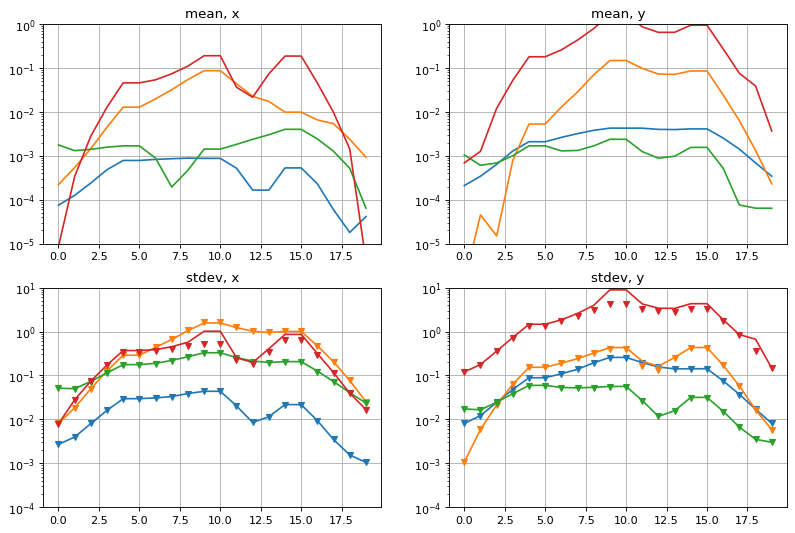

In [13]:
fig, ax = plt.subplots(2,2, figsize=(12, 8), dpi=80)
ax[0,0].semilogy(np.abs(np.mean(e_db_x, axis=0)),'-C0')
ax[0,0].semilogy(np.abs(np.mean(e_fb_x, axis=0)),'-C1')
ax[0,0].semilogy(np.abs(np.mean(e_dr_x, axis=0)),'-C2')
ax[0,0].semilogy(np.abs(np.mean(e_fr_x, axis=0)),'-C3')
ax[0,0].set_title('mean, x')
ax[0,0].grid()
ax[0,0].set_ylim([1e-5, 1e0])
ax[0,1].semilogy(np.abs(np.mean(e_db_y, axis=0)),'-C0')
ax[0,1].semilogy(np.abs(np.mean(e_fb_y, axis=0)),'-C1')
ax[0,1].semilogy(np.abs(np.mean(e_dr_y, axis=0)),'-C2')
ax[0,1].semilogy(np.abs(np.mean(e_fr_y, axis=0)),'-C3')
ax[0,1].set_title('mean, y')
ax[0,1].grid()
ax[0,1].set_ylim([1e-5, 1e0])
ax[1,0].semilogy(np.std(e_db_x, axis=0),'-C0')
ax[1,0].semilogy(np.sqrt(crlb_x_directbearing),'vC0')
ax[1,0].semilogy(np.std(e_fb_x, axis=0),'-C1')
ax[1,0].semilogy(np.sqrt(crlb_x_diffbearing),'vC1')
ax[1,0].semilogy(np.std(e_dr_x, axis=0),'-C2')
ax[1,0].semilogy(np.sqrt(crlb_x_directrange),'vC2')
ax[1,0].semilogy(np.std(e_fr_x, axis=0),'-C3')
ax[1,0].semilogy(np.sqrt(crlb_x_diffrange),'vC3')
ax[1,0].set_title('stdev, x')
ax[1,0].grid()
ax[1,0].set_ylim([1e-4, 1e1])
ax[1,1].semilogy(np.std(e_db_y, axis=0),'-C0')
ax[1,1].semilogy(np.sqrt(crlb_y_directbearing),'vC0')
ax[1,1].semilogy(np.std(e_fb_y, axis=0),'-C1')
ax[1,1].semilogy(np.sqrt(crlb_y_diffbearing),'vC1')
ax[1,1].semilogy(np.std(e_dr_y, axis=0),'-C2')
ax[1,1].semilogy(np.sqrt(crlb_y_directrange),'vC2')
ax[1,1].semilogy(np.std(e_fr_y, axis=0),'-C3')
ax[1,1].semilogy(np.sqrt(crlb_y_diffrange),'vC3')
ax[1,1].set_title('stdev, y')
ax[1,1].grid()
ax[1,1].set_ylim([1e-4, 1e1])
plt.show()

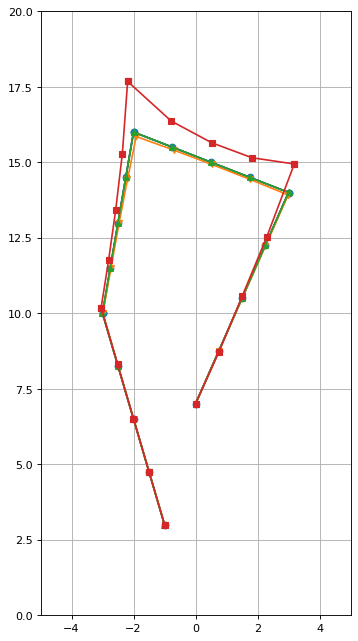

In [14]:
fig, ax = plt.subplots(figsize=(5, 10), dpi=80)
ax.plot(x, y, 'k')
ax.plot(np.mean(est_x_directbearing,axis=0), np.mean(est_y_directbearing,axis=0),'-oC0')
ax.plot(np.mean(est_x_diffbearing,axis=0), np.mean(est_y_diffbearing,axis=0),'-vC1')
ax.plot(np.mean(est_x_directrange,axis=0), np.mean(est_y_directrange,axis=0),'-^C2')
ax.plot(np.mean(est_x_diffrange,axis=0), np.mean(est_y_diffrange,axis=0),'-sC3')
plt.xlim([-5,5])
plt.ylim([0,20])
ax.grid()
plt.show()

In [15]:
np.savez('crlb_classical_raindirectsun.npz', 
        x=x, y=y, c=c, f_e = f_e,
        d_rxL_txL=d_rxL_txL, d_rxR_txL=d_rxR_txL, d_rxL_txR=d_rxL_txR, d_rxR_txR=d_rxR_txR, 
        deld_rxLR_txL = deld_rxLR_txL, deld_rxLR_txR = deld_rxLR_txR,
        aoa_rxL_txL=aoa_rxL_txL, aoa_rxR_txL=aoa_rxR_txL, aoa_rxL_txR=aoa_rxL_txR, aoa_rxR_txR=aoa_rxR_txR, 
        delaoa_rxLR_txL = delaoa_rxLR_txL, delaoa_rxLR_txR = delaoa_rxLR_txR,
        est_x_directbearing=est_x_directbearing, est_y_directbearing=est_y_directbearing,
        est_x_diffbearing=est_x_diffbearing, est_y_diffbearing=est_y_diffbearing,
        est_x_directrange=est_x_directrange, est_y_directrange=est_y_directrange,
        est_x_diffrange=est_x_diffrange, est_y_diffrange=est_y_diffrange,
        f_adc_clk=f_adc_clk,
        daynight=daynight,
        weather=weather,
        temperature=temperature)